# Read an ISRed image mosaic from the butler and fit ghost spots

## Setup and imports

In [1]:
! eups list -s lsst_distrib

   g4213664e8e+b08e1c1b0b 	current w_2024_04 setup


In [2]:
# plotting
import pylab as plt
import numpy as np

# butler
from lsst.daf.butler import Butler

# isr and display
import lsst.afw.display as afwDisplay
from lsst.afw.image import Image

# camera stuff
import lsst.afw.math as afwMath
from lsst.afw.cameraGeom import utils as cgu
from lsst.obs.lsst import LsstCam

# Astropy nice plotting
from astropy.visualization import imshow_norm, MinMaxInterval, AsinhStretch, LinearStretch, \
                                  SqrtStretch,ContrastBiasStretch,ZScaleInterval, \
                                  AsymmetricPercentileInterval,ManualInterval



## Helpers

In [3]:
def displayExposure(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    afw_display.setImageColormap(cmap='gray')
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')
    return afw_display

def displayImage(image,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    #afw_display.scale('linear', min=-5, max=10)
    afw_display.setImageColormap(cmap='plasma')
    afw_display.mtv(image)
    plt.title(title)
    plt.gca().axis('off')
    return afw_display

def displayImageGhosts(image, title=None, frame_size=16, display=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    if display is None:
        fig = plt.figure(figsize=(frame_size,frame_size))
        afw_display = afwDisplay.Display(frame=fig)
    else:
        afw_display = display
    #afw_display.scale('asinh', 'zscale')
    afw_display.scale('linear', min=0, max=20)
    afw_display.setImageColormap(cmap='plasma')
    afw_display.mtv(image)
    plt.title(title)
    #plt.gca().axis('off')
    return afw_display

def show_hv_slices(imgarray, vpix, hpix, ccdname):
    """ Usage:
    show_hv_slices(imageF.getArray(), vpix=6300, hpix=2780, ccdname='random')
    """ 
    plt.rcParams["figure.figsize"] = [12, 6]
    fig, ax = plt.subplots(1, 2)
    subax = imgarray[vpix]
    x = range(len(subax))
    ax[0].plot(x, subax)
    ax[0].set_title(f'Horizontal slice on {ccdname} at pixel {vpix}')
    subay = np.transpose(imgarray)[hpix]
    y = range(len(subay))
    ax[1].plot(y, subay)
    ax[1].set_title(f'Vertical slice on {ccdname} at pixel {hpix}')

    

## Connect to the Butler repository

In [4]:
def idtoobs(img_id):    
    """ 3023062500401 -> MC_C_20230625_000401
    """
    day_obs = str(img_id)[2:8]
    seq_num = str(img_id)[8:]
    return f'MC_C_{day_obs}_{seq_num}'

def reftoseq(ref):
    """ u/bregeon/eo_focal_plane_mosaic_3023062500405_w_2024_12 -> 405
    """
    return ref.run.split('_')[4][-3:]
    

In [5]:
import lsst.daf.butler as daf_butler
repo = "/sdf/data/rubin/repo/ir2"
butler = daf_butler.Butler(repo)

In [6]:
collections = butler.registry.queryCollections(f"u/bregeon/eo_focal_plane_mosaic*",
                                               collectionTypes=daf_butler.CollectionType.CHAINED)
for item in collections[:5]:
    print(item)

u/bregeon/eo_focal_plane_mosaic_3023062500411_w_2024_12
u/bregeon/eo_focal_plane_mosaic_3023062500405_w_2024_12
u/bregeon/eo_focal_plane_mosaic_3023062500403_w_2024_12
u/bregeon/eo_focal_plane_mosaic_3023062500401_w_2024_12
u/bregeon/eo_focal_plane_mosaic_3023062500409_w_2024_12


In [7]:
# Choose image to analyse from exposure id
exposure_id = 3023062500401
obs_id =idtoobs(exposure_id)

In [8]:
myrefs=list(set(butler.registry.queryDatasets(datasetType='eoFpMosaic',
                                       instrument='LSSTCam',
                                       where=f"exposure.id={exposure_id}",
                                       collections=collections)))
myrefs

[DatasetRef(DatasetType('eoFpMosaic', {instrument}, ImageF), {instrument: 'LSSTCam'}, run='u/bregeon/eo_focal_plane_mosaic_3023062500409_w_2024_12/20240416T154019Z', id=25e5b331-00f5-4719-8d71-8ef0c9c684e6),
 DatasetRef(DatasetType('eoFpMosaic', {instrument}, ImageF), {instrument: 'LSSTCam'}, run='u/bregeon/eo_focal_plane_mosaic_3023062500405_w_2024_12/20240416T153904Z', id=e5f492e8-1c8a-4266-a8a7-bd930640d31b),
 DatasetRef(DatasetType('eoFpMosaic', {instrument}, ImageF), {instrument: 'LSSTCam'}, run='u/bregeon/eo_focal_plane_mosaic_3023062500403_w_2024_12/20240416T153818Z', id=151c2e60-9769-4120-89c0-6c446e9b75be),
 DatasetRef(DatasetType('eoFpMosaic', {instrument}, ImageF), {instrument: 'LSSTCam'}, run='u/bregeon/eo_focal_plane_mosaic_3023062500401_w_2024_12/20240404T204600Z', id=da78f4fa-9097-47da-ace2-e96bf2be9f3c)]

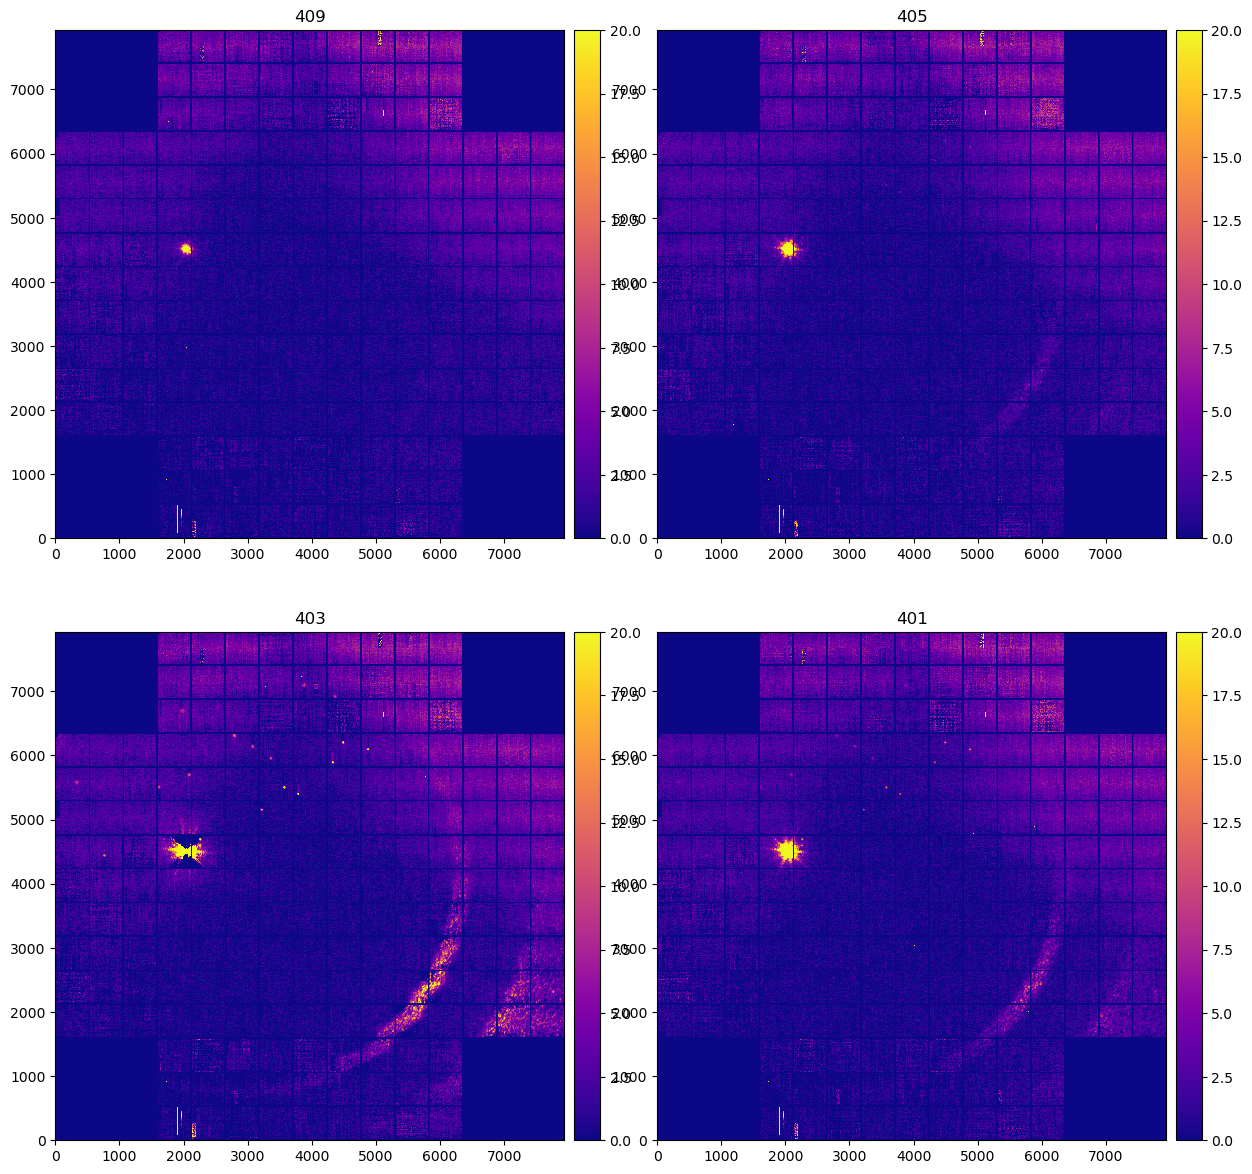

In [9]:
# Plot images of all refs
afwDisplay.setDefaultBackend('matplotlib') 
fig, ax = plt.subplots(2, 2, constrained_layout=True, figsize=(12, 12))
display = afwDisplay.Display(frame=fig)
axs = ax.ravel()
for i, ref in enumerate(myrefs):
    fig.sca(axs[i])
    seq_num = reftoseq(ref)
    displayImageGhosts(butler.get(ref), title=seq_num, display=display)


In [12]:
# Analyzing 401
imageF = butler.get(myrefs[3])

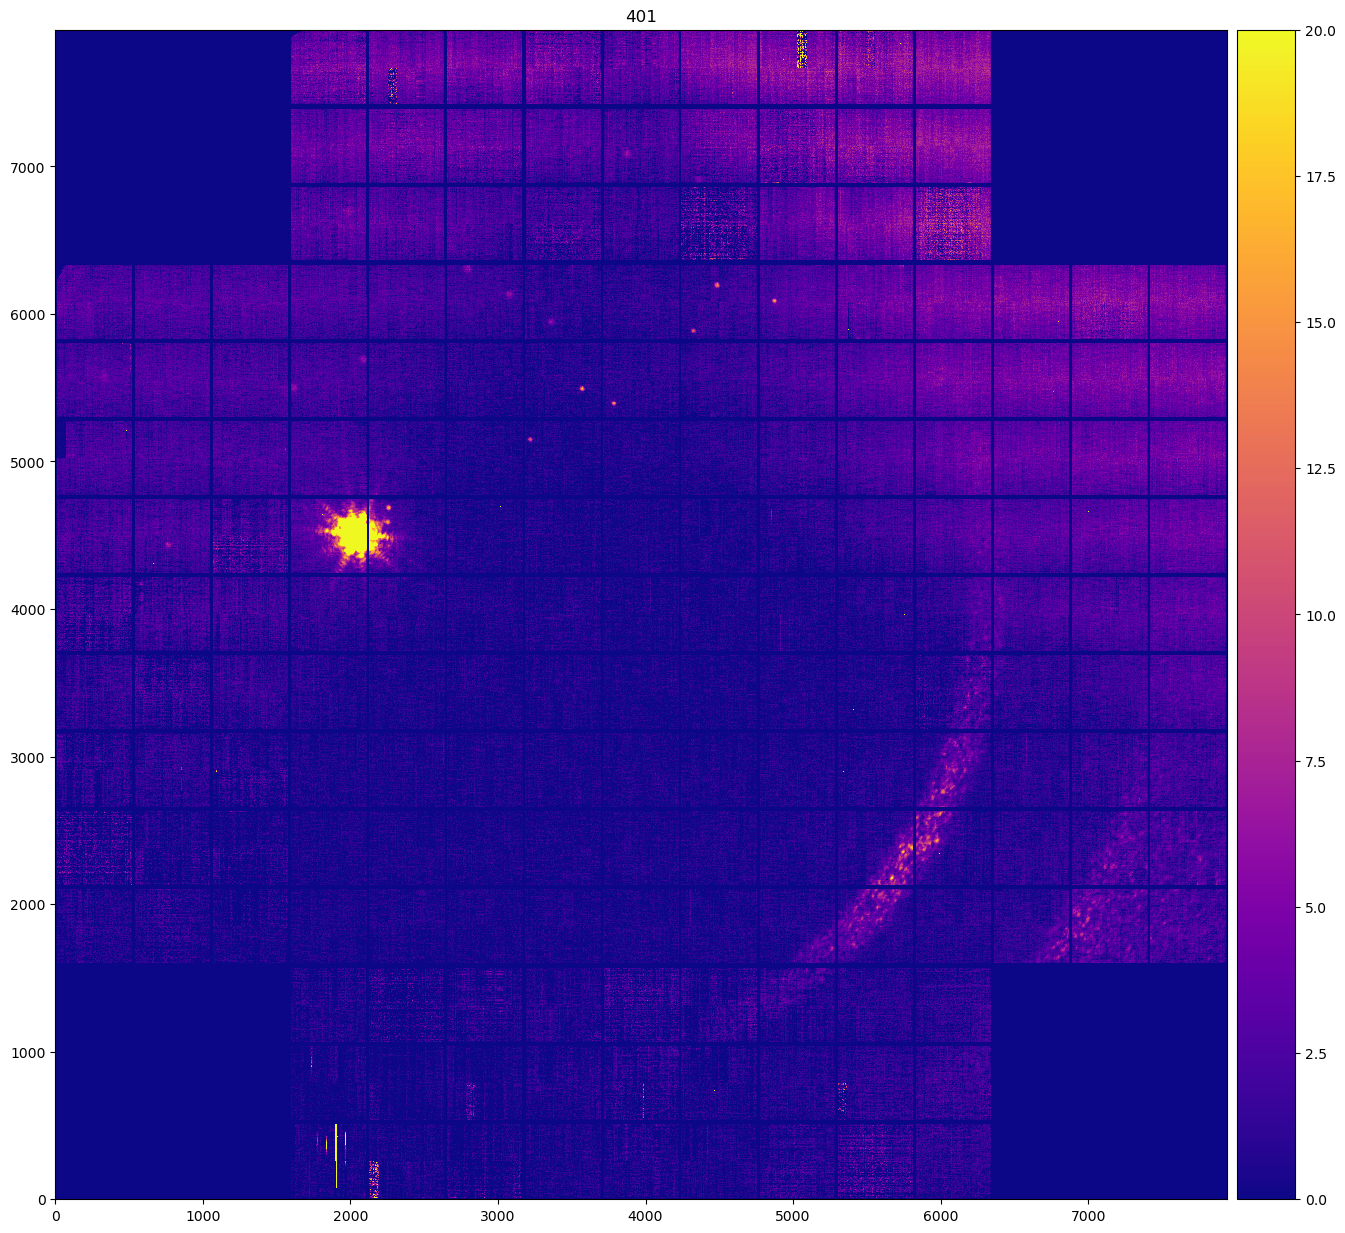

In [13]:
displayImageGhosts(imageF, title="401")
#afw_display.interact()
#afw_display.zoom(zoomfac=50, colc=750, rowc=4500)


In [14]:
class spot_fitter(object):
    """ 
    """
    def __init__(self, obs_id, mosaic):
        """ Constructor """
        self.obs_id = obs_id
        self.imageF = mosaic
        
    def _gaussian(self, bkg, height, center_x, center_y, width):
        """ Returns a gaussian function with the given parameters
        """
        width = float(width)
        bkg = float(bkg)
        return lambda x,y: bkg + height*np.exp(
                    -(((center_x-x)/width)**2+((center_y-y)/width)**2)/2)
    
    def _moments(self, data):
        """ Returns (height, x, y, width)
        the gaussian parameters of a 2D distribution by calculating its
        moments """
        total = data.sum()
        X, Y = np.indices(data.shape)
        x = (X*data).sum()/total
        y = (Y*data).sum()/total
        col = data[:, int(y)]
        width = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
        row = data[int(x), :]
        height = data.max()
        bkg = data.mean()
        # x = 100
        # y = 100
        return bkg, height, x, y, width
    
    def _optimize(self, data):
        """ Returns (height, x, y, width)
        the gaussian parameters of a 2D distribution found by a fit"""
        from scipy import optimize
        params = self._moments(data)
        errorfunction = lambda p: np.ravel(self._gaussian(*p)(*np.indices(data.shape)) -
                                     data)
        p, success = optimize.leastsq(errorfunction, params)
        return p

    def make_stamp(self, x_center, y_center, ds=100):
        """ Make a stamp image around a ghost position
        """
        from lsst.geom import Point2I, Box2I
        ghost_box = Box2I(minimum=Point2I(x=x_center-ds, y=y_center-ds), maximum=Point2I(x=x_center+ds, y=y_center+ds))
        ghost_stamp = self.imageF[ghost_box]   # same as no ImageOrigin argument
        return ghost_stamp

    def fit_gaussian(self, ghost_stamp):
        """ Fit a 2D gaussian on a ghost stamp
        """
        # data - transpose for the fit
        stamp_array = np.transpose(ghost_stamp.getArray())
        # Fit centered in (100,100)
        params = self._optimize(stamp_array)
        # verification
        # fit = gaussian(*params)
        # plt.matshow(cutout, cmap='plasma')
        # plt.contour(fit(*np.indices(cutout.shape)), cmap=plt.cm.copper)
        # Move Gaussian to focal plane coordinates
        rc_params = params.copy()
        rc_params[2] = params[2]+ghost_stamp.getX0()
        rc_params[3] = params[3]+ghost_stamp.getY0()
        rc_fit = self._gaussian(*rc_params)
        return rc_params
            
    def run_fit(self, ghost_xy, dsl=[100, 75, 50, 30]):
        """ Iterate on different windows size to get all fits fine
        """
        for ds in dsl:
            ghost_stamp = self.make_stamp(*ghost_xy, ds=ds)
            bkg, height, x, y, width = self.fit_gaussian(ghost_stamp)
            if abs(x-ds)>ds/2. or abs(y-ds)>ds/2.:
                continue
            else:
                break    
        return [bkg, height, x, y, width]

    def display_ghost_fit(self, ghost_stamp, params, display=None):
        """ Display a ghost stamp and parameters of the spot, usually coming from a fit
        """
        # plot ghosts stamp
        afwdisplay = displayImageGhosts(ghost_stamp, title=self.obs_id, frame_size=5, display=display)
        
        # build gaussian function
        gauss2d = self._gaussian(*params)

        # plot gaussian contours 
        bbox = ghost_stamp.getBBox()
        plt.contour(bbox.x.range(), bbox.y.range(), gauss2d(*bbox.grid()),
                    levels=2, cmap="plasma")
        
        # write params on plot
        ax = plt.gca()
        (bkg, height, x, y, width) = params
        plt.text(0.95, 0.05, """
        bkg : %.1f
        height : %.1f
        x : %.3f
        y : %.3f
        width : %.3f""" %(bkg, height, x, y, width),
                fontsize=16, horizontalalignment='right',
                verticalalignment='bottom', transform=ax.transAxes)    
        print(f'Params (bkg, height, x, y, width): {bkg:.1f}, {height:.1f}, {x:.3f}, {y:.3f}, {width:.3f}')
        return afwdisplay

    def fit_and_display(self, ghost_xy, ds=100, display=None):    
        """ Run the fit and display results
        """
        params = self.run_fit(ghost_xy)
        ghost_stamp = self.make_stamp(*ghost_xy, ds=ds)
        self.display_ghost_fit(ghost_stamp, params, display=display)
        return params


###########################
# Deprecated
def show_ghost_fit(obs_id, ghost_stamp, params):
    # plot ghosts stamp
    bbox = ghost_stamp.getBBox()
    plt.imshow(ghost_stamp.getArray(), cmap='plasma', vmin=0, vmax=20,
               extent=[bbox.getMinX(), bbox.getMaxX(), bbox.getMaxY(), bbox.getMinY()])
    plt.title(obs_id)

    # define fit function
    gauss2d = gaussian(*params)
    # plot gaussian contours 
    plt.contour(bbox.x.range(), bbox.y.range(), gauss2d(*bbox.grid()), cmap=plt.cm.copper)
    
    ax = plt.gca()
    (bkg, height, x, y, width) = params
    plt.text(0.95, 0.05, """
    bkg : %.1f
    height : %.1f
    x : %.3f
    y : %.3f
    width : %.3f""" %(bkg, height, x, y, width),
            fontsize=16, horizontalalignment='right',
            verticalalignment='bottom', transform=ax.transAxes)    
    print(f'Params (bkg, height, x, y, width): {bkg:.1f}, {height:.1f}, {x:.3f}, {y:.3f}, {width:.3f}')


    

In [15]:
gf = spot_fitter(obs_id, imageF)


Params (bkg, height, x, y, width): 2.7, 14.3, 4874.298, 6084.908, 9.061


[2.7429521735004117,
 14.34669111290902,
 4874.297879333964,
 6084.908268644551,
 9.061205408572194]

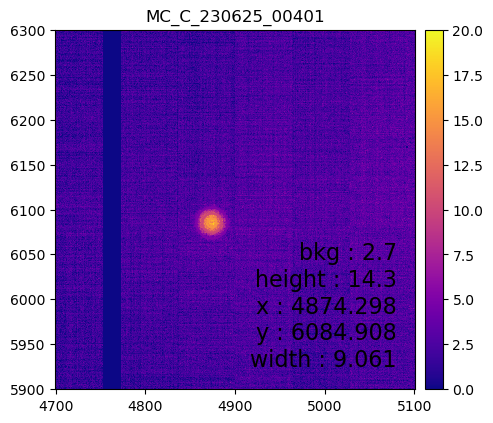

In [16]:
gf.fit_and_display((4900, 6100), ds=200, display=None)

Params (bkg, height, x, y, width): 3.8, 12.8, 2252.056, 4586.376, 11.245


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:494: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


[3.822387930442941,
 12.795303247893468,
 2252.0564179025687,
 4586.37621222447,
 11.24535208780881]

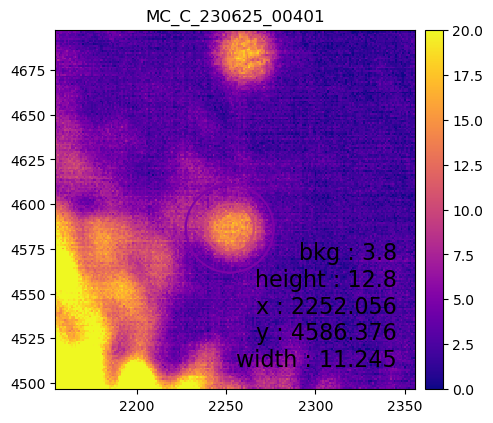

In [17]:
gf.fit_and_display((2255, 4597))

In [18]:
targets=[(3086.0695851985665, 6141.6332940262),
 (2007.7430569340174, 6715.706409792939),
 (4490.221395384779, 6215.331869698957),
 (758.7461429009786, 4442.687181148961),
 (4366.09747846224, 6936.8021368112095),
 (3784.2666178878435, 5404.647537298631),
 (2263.7486355867522, 4706.4505046093545),
 (2085.3205050106035, 5699.441839989659),
 (3877.3595555797465, 7095.835905368211),
 (4878.1086357677095, 6106.723442391736),
 (4319.551009616289, 5897.264332584953),
 (3225.708991736422, 5164.157448261213),
 (332.07017847975396, 5567.560178259461),
 (3559.2920184657432, 5505.498219798193),
 (1612.0980717434275, 5513.255964605852),
 (2806.7907721228557, 6312.30367979469),
 (3357.5906534666183, 5939.931929027076),
 (2255.990890779093, 4597.8420773021335)]

In [19]:
spots_x = [one[0] for one in targets]
spots_y = [one[1] for one in targets]

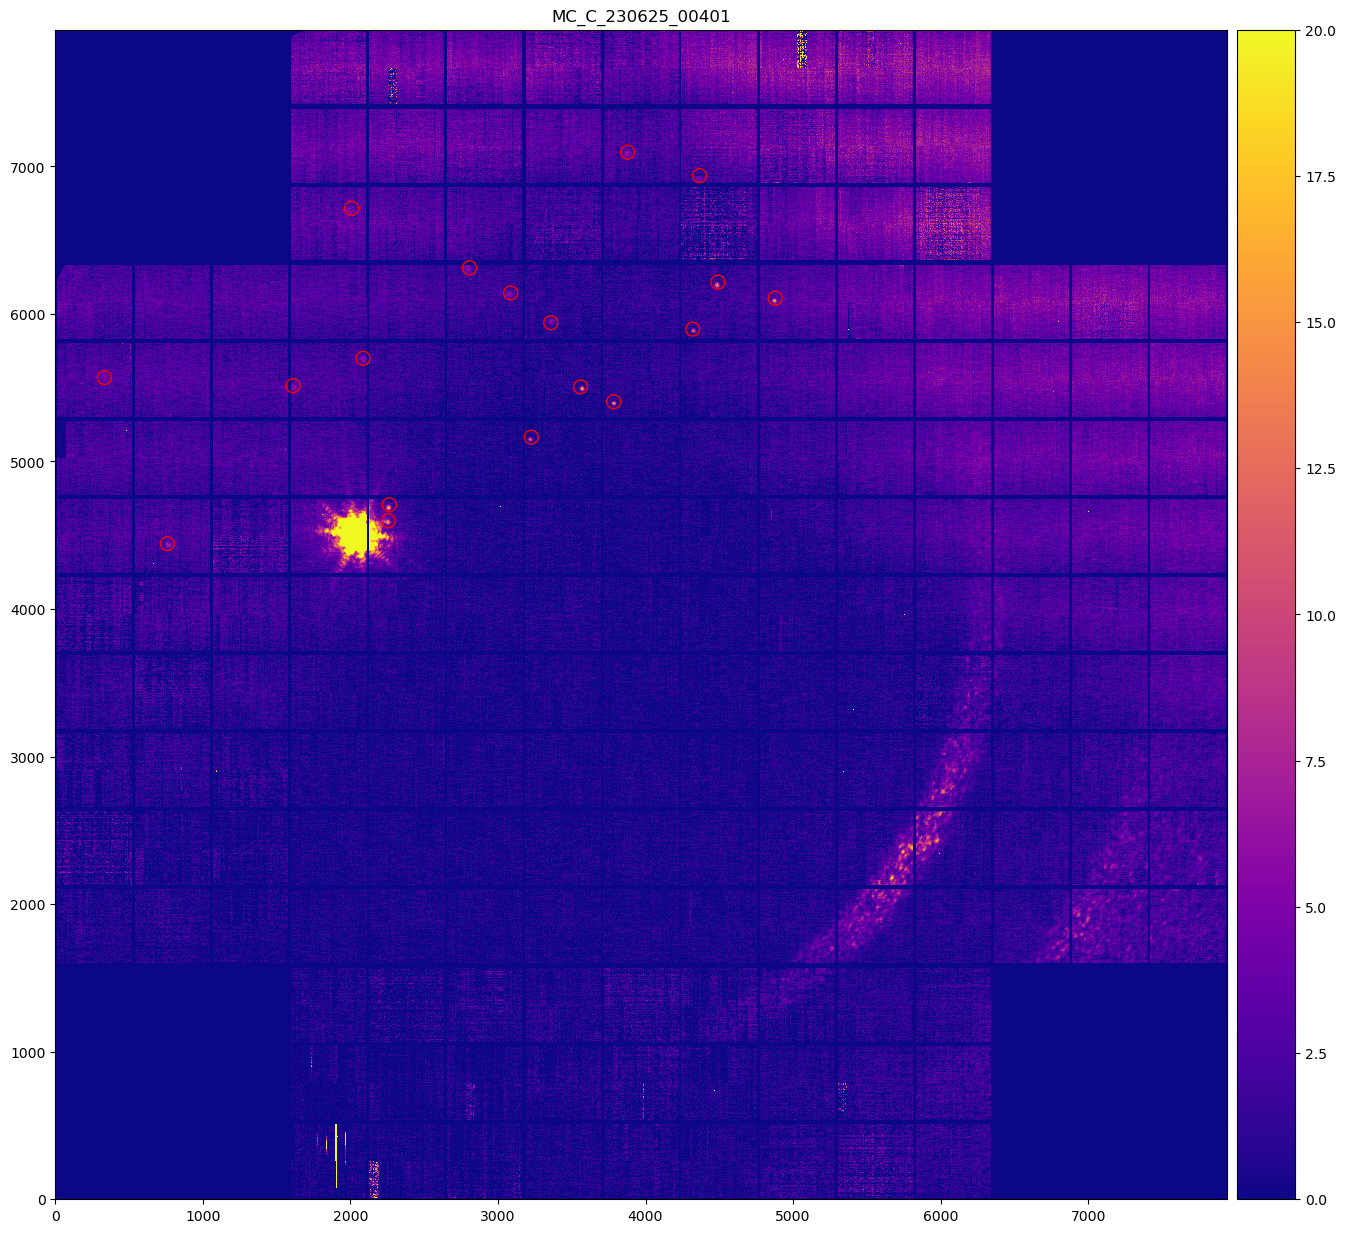

In [20]:
displayImageGhosts(imageF, title=obs_id)
plt.scatter(spots_x, spots_y, s=100, facecolors='none', edgecolors='r', linewidths=1)

In [21]:
#########################################
# Deprecated
#########################################
def fit_and_display_ghosts(obs_id, targets_list):
    n_cols = 5
    n_rows=4
    fig, ax = plt.subplots(n_cols, n_rows, constrained_layout=True, figsize=(32, 32))
    display = afwDisplay.Display(frame=fig)
    plt.title(obs_id)
    axs = ax.ravel()
    spots_list = []
    for i, spot in enumerate(targets_list):
        fig.sca(axs[i])
        params = fit_ghost_iter(spot)
        ghost_stamp = make_stamp(*spot, ds=100)
        display_ghost_fit(obs_id, ghost_stamp, params, display=display)
        spots_list.append(params)
    return spots_list

def plot_ghosts_mosaic(targets_list):
    from lsst.afw.display.utils import Mosaic
    plt.rcParams["figure.figsize"] = [12, 12]
    # image list
    images = []
    for i, spot in enumerate(targets_list):
        images.append(make_stamp(*spot))
    # Mosaic
    m = Mosaic(gutter=30, background=0, mode='square')
    mosaic = m.makeMosaic(images)
    display = afwDisplay.Display(999)
    display.scale('linear', min=0, max=20)
    display.setImageColormap(cmap='plasma')
    display.mtv(mosaic)
    return m, display

def fit_and_map_ghosts(obs_id, targets_list):
    n_cols = 5
    n_rows=4
    fig, ax = plt.subplots(n_cols, n_rows, constrained_layout=True, figsize=(32, 32))
    plt.title(obs_id)
    axs = ax.ravel()
    spots_list = []
    for i, spot in enumerate(targets_list):
        fig.add_subplot(axs[i])
        fig.sca(axs[i])
        params = fit_ghost_iter(spot)
        ghost_stamp = make_stamp(*spot, ds=100)
        show_ghost_fit(obs_id, ghost_stamp, params)
        spots_list.append(params)
    return spots_list




In [22]:
def process_mosaic(obs_id, imageF, targets_list):
    """ Fit all targets on a mosaic
    """
    # prepare fitter
    gf = spot_fitter(obs_id, imageF)
    # prepare figure
    n_cols = 5
    n_rows = 4
    fig, ax = plt.subplots(n_cols, n_rows, constrained_layout=True, figsize=(32, 32))
    display = afwDisplay.Display(frame=fig)
    plt.title(obs_id)
    axs = ax.ravel()
    # fit all targets
    spots_list = []
    for i, spot in enumerate(targets_list):
        fig.sca(axs[i])
        params = gf.fit_and_display(spot, ds=100, display=display)
        spots_list.append(params)
    return spots_list
    


In [ ]:
spots_list = process_mosaic(obs_id, imageF, targets)

Params (bkg, height, x, y, width): 1.2, 4.7, 3078.286, 6129.444, 17.645
Params (bkg, height, x, y, width): 3.2, 2.1, 1990.223, 6695.489, 17.082
Params (bkg, height, x, y, width): 1.3, 14.3, 4485.440, 6192.988, 10.972
Params (bkg, height, x, y, width): 2.0, 5.2, 768.215, 4430.468, 16.247
Params (bkg, height, x, y, width): 1.8, 2.6, 4364.673, 6908.816, 16.175
Params (bkg, height, x, y, width): 0.8, 15.6, 3785.719, 5390.712, 9.199
Params (bkg, height, x, y, width): 1.4, 16.0, 2260.275, 4683.572, 11.433
Params (bkg, height, x, y, width): 0.3, 6.0, 2085.018, 5689.978, 21.522
Params (bkg, height, x, y, width): 2.2, 3.6, 3876.072, 7081.837, 21.267
Params (bkg, height, x, y, width): 2.5, 14.7, 4873.703, 6084.862, 9.554


In [ ]:
def df_from_spots(spots_list, exposure_id=None):
    """ Make a nice panda dataframe of the list of spots position
    """
    import pandas as pd 
    df = pd.DataFrame(spots_list, columns =['bkg', 'height', 'x', 'y', 'width'])
    df['exposure_id'] = exposure_id
    return df


In [ ]:
df = df_from_spots(spots_list, exposure_id)
df

In [ ]:
displayImageGhosts(imageF, title=obs_id, frame_size=10)
plt.scatter(df.x, df.y, s=100, facecolors='none', edgecolors='r', linewidths=1)

In [ ]:
from lsst.afw import cameraGeom
from lsst.obs.lsst import LsstCam
camera = LsstCam.getCamera()
# tx = camera.getTransform(cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
#    cam_x, cam_y = tx.getMapping().applyForward(np.vstack((x, y)))
#    return cam_x.ravel(), cam_y.ravel()